<a href="https://colab.research.google.com/github/TheAmirHK/Financial-market-analysis/blob/main/Stock_price_forecasting_ARIMA_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import datetime
from datetime import datetime, date, timedelta
import yfinance as yf
yf.pdr_override() # <== that's all it takes :-)
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Series

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , mean_absolute_percentage_error, r2_score, mean_absolute_error
from tqdm import tqdm
# For warnings suppression
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The stocks to be analyzed !
stock = ["AAPL"]

# define the number of year to be studied
NYears = 5

# Define the time period of study
end = datetime.today()
start = end - timedelta(days = NYears*365)
# Download stock data
data = pdr.get_data_yahoo(stock, start, end)

[*********************100%%**********************]  1 of 1 completed


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 1131
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -2580.383
Date:                Thu, 23 Nov 2023   AIC                           5166.766
Time:                        16:44:20   BIC                           5181.856
Sample:                             0   HQIC                          5172.467
                               - 1131                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0571      0.023     -2.503      0.012      -0.102      -0.012
ar.L2         -0.0325      0.023     -1.395      0.163      -0.078       0.013
sigma2         5.6360      0.159     35.395      0.0

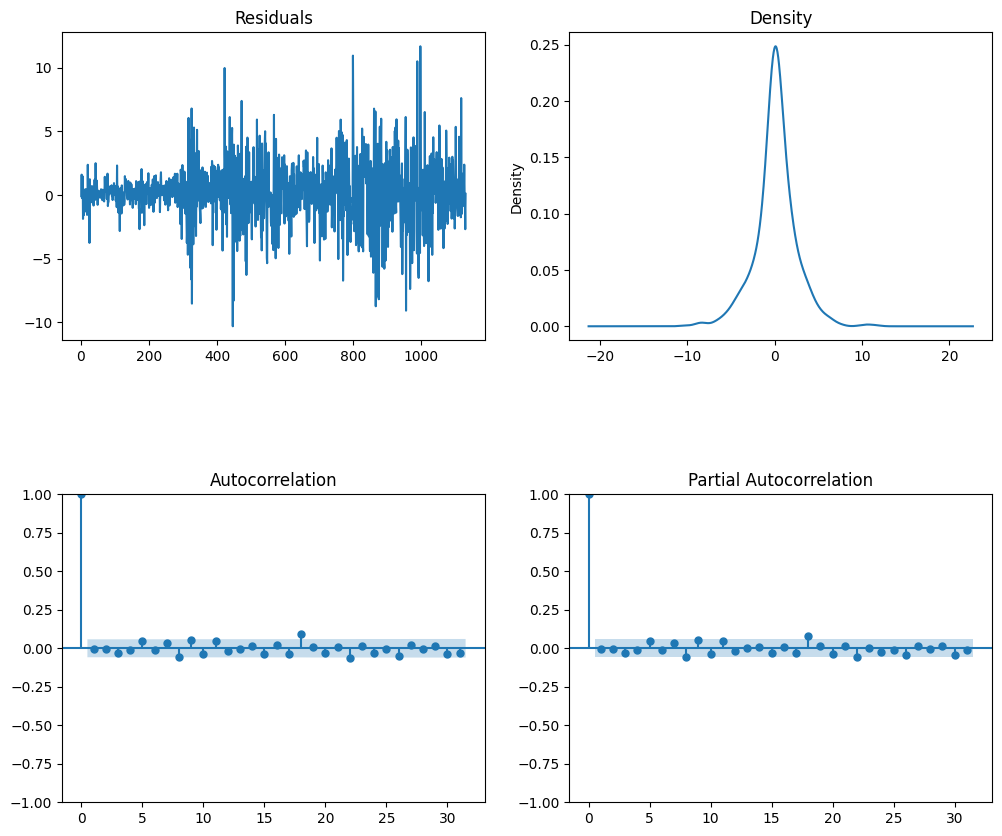

count    1130.000000
mean        0.124907
std         2.371780
min       -10.311150
25%        -0.867967
50%         0.130560
75%         1.239137
max        11.689349
dtype: float64


In [3]:
""" Using AutoRegressive Integrated Moving Average (ARIMA) method to forecast the future price of a stock:
ARIMA method predicts future price of a atock examining the differences between values in the series instead of through actual values.

ARIMA method includes parameters such as p, d, and q, where:
p: the number of lag observations in the model.
d: degree of differencing.
q: order of the moving average.

"""
# Autocorrelation test and transforming non-stationary time-series to stationary using differencing for ARIMA
def diff_data(data, plot=None):
    adf_test = adfuller(data)
    #print(f'p-value: {adf_test[1]}')
    count_diff = 0
    while adf_test[1]>0.05 : # continue differences till p-value is less than 5 percents
      df_train_diff = data.diff().dropna()
      count_diff += 1
      adf_test = adfuller(df_train_diff)
    if plot is not None:
        df_train_diff.plot()
        acf_diff = plot_acf(df_train_diff)
        pacf_diff = plot_pacf(df_train_diff)
    return count_diff


# Define train and valid data
def split_data (data , test_size= None, split_date=None):

    input = pd.DataFrame(data)
    input["date"]= input.index
    input = input.set_index('date')
    input = input.reset_index(drop=True)

    if ((split_date is not None) and (test_size is None)):
      split_date = pd.Timestamp(split_date)
      train  = input[: split_date].dropna()
      valid = input[split_date : ].dropna()

    elif ((split_date is None) and (test_size is not None)):
      train, valid = train_test_split(input, test_size=test_size, shuffle=False)

    return train, valid

# Evaluate the dependency between an observation and a residual error from a moving average model applied to lagged observations
def analyse_res(data):
    residuals = data.resid[1:]
    fig, ax = plt.subplots(2,2,figsize=(12, 10))
    plt.subplots_adjust(hspace=0.5)
    residuals.plot(title='Residuals', ax=ax[0,0])
    residuals.plot(title='Density', kind='kde', ax=ax[0,1])
    acf_res = plot_acf(residuals, ax=ax[1,0])
    pacf_res = plot_pacf(residuals, ax=ax[1,1])
    plt.show()
    print(residuals.describe())
    return

train_set = data["Adj Close"]
train, valid = split_data (train_set , test_size= 0.1, split_date=None)
n_d = diff_data(train)
arima_model = ARIMA(train, order=(2,n_d,0))
model_fit = arima_model.fit()
print(model_fit.summary())
analyse_res(model_fit)

In [ ]:
# ARIMA Walk Forward Validation for checking the validity of the model
test_size = 0.1
train_size = np.int(len(train_set) *(1-test_size))
last_index = len(train_set)
predictions = list()
valids = list()

for i in tqdm(range(train_size, last_index)):
    train, valid = train_set[0:i], train_set[i:i+1]
    d = diff_data(train)
    model = ARIMA(train, order=(2,d,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output
    predictions.append(yhat)
    valids.append(valid)

ARIMA method MAPE = 0.009 


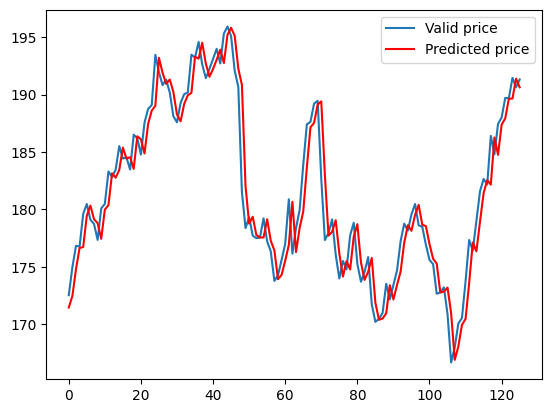

In [8]:
# evaluate model using MAPE score
ARIMA_MAPE = mean_absolute_percentage_error(valids, predictions)
print("ARIMA method MAPE = %0.3f "%ARIMA_MAPE)
# plot predictions against actual outcomes
plt.plot(valids, label="Valid price")
plt.plot(predictions, color='red', label ="Predicted price")
plt.legend()
plt.show()